<a href="https://colab.research.google.com/github/sachinthadilshann/pytorch_course_by_DanielBourke/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with PyTorch

## 1. Make classification data and get it ready

In [2]:
from sklearn.datasets import make_circles
import pandas as pd
import numpy as np
import torch

n_samples = 1000

X , y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [3]:
len(X) , len(y)

(1000, 1000)

In [4]:
#y

In [5]:
circles = pd.DataFrame({"X1":X[:,0],
                       "X2":X[:,1],
                       "label":y})

In [6]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


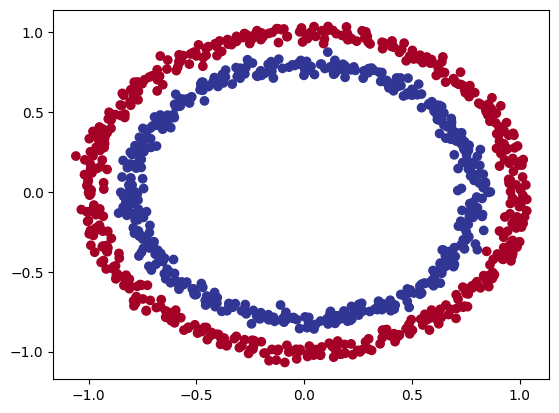

In [7]:
import matplotlib.pyplot as plt


plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1. Chech input and output shape

In [8]:
X.shape , y.shape

((1000, 2), (1000,))

In [9]:
X_sample = X[0]
y_sample = y[0]

print(f"Sample input features: {X_sample} and target: {y_sample}")
print(f"Input shape: {X_sample.shape} and target shape: {y_sample.shape}")

Sample input features: [0.75424625 0.23148074] and target: 1
Input shape: (2,) and target shape: ()


## 1.2 Turn data into tensor

In [10]:
type(X)

numpy.ndarray

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
type(X)

torch.Tensor

In [13]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,random_state=42)


In [15]:
len(X_train) , len(X_test)


(800, 200)

In [16]:
len(y_train),len(y_test)

(800, 200)

## Building Model

In [17]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [19]:
X_train.shape


torch.Size([800, 2])

In [20]:
y_train[:1]

tensor([1.])

In [21]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

    self.two_linear = nn.Sequential(
        self.layer_1,
        self.layer_2
    )

  def forward(self,x):
    return self.layer_2(self.layer_1(x))  # x -> layer 1 -> layer 2 -> output
    return self.two_linear(x)


model_0 = CircleModelV0().to(device)
model_0





CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (two_linear): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [22]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.1636],
        [0.1201],
        [0.2619],
        [0.1358],
        [0.2369],
        [0.2105],
        [0.1078],
        [0.1289],
        [0.2628],
        [0.1169]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


###2.1 Setup loss function and optimizer

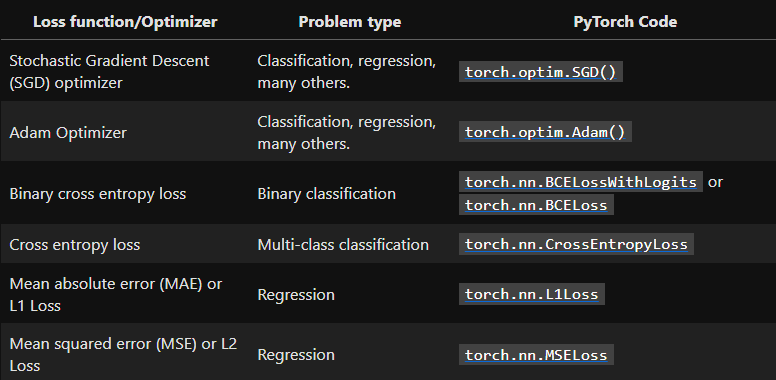

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

In [26]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## Train Model

1. Forward pass
2. Calculate loss
3. Zero gradients
4. Perform backpropagation on the loss
5. Step the optimizer

### 3.1 Going from raw logits -> prediction probabilities -> predicition labels

In [27]:
model_0.eval()
with torch.inference_mode():
  y_logit = model_0(X_test.to(device))[:5]
y_logit

tensor([[0.1636],
        [0.1201],
        [0.2619],
        [0.1358],
        [0.2369]], device='cuda:0')

In [28]:
y_pred_prob = torch.sigmoid(y_logit)
y_pred_prob

tensor([[0.5408],
        [0.5300],
        [0.5651],
        [0.5339],
        [0.5589]], device='cuda:0')

In [29]:
y_preds = torch.round(y_pred_prob)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_labels

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [30]:
epochs =100

X_train,y_train = X_train.to(device),y_train.to(device)
x_test,y_test = X_test.to(device),y_test.to(device)

for epochs in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss = loss_fn(torch.sigmoid(y_logits),
  #               y_train)

  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)



  if epochs % 10 == 0:
    print(f"Epoch: {epochs} | Loss: {loss:.5f} | Acc: {acc:.5f} | Test loss: {test_loss:.2f}% | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69916 | Acc: 50.00000 | Test loss: 0.70% | Test Acc: 50.00%
Epoch: 10 | Loss: 0.69599 | Acc: 50.00000 | Test loss: 0.69% | Test Acc: 50.00%
Epoch: 20 | Loss: 0.69475 | Acc: 57.50000 | Test loss: 0.69% | Test Acc: 61.00%
Epoch: 30 | Loss: 0.69422 | Acc: 53.62500 | Test loss: 0.69% | Test Acc: 54.50%
Epoch: 40 | Loss: 0.69396 | Acc: 50.87500 | Test loss: 0.69% | Test Acc: 54.00%
Epoch: 50 | Loss: 0.69380 | Acc: 50.62500 | Test loss: 0.69% | Test Acc: 54.50%
Epoch: 60 | Loss: 0.69369 | Acc: 50.50000 | Test loss: 0.69% | Test Acc: 54.50%
Epoch: 70 | Loss: 0.69361 | Acc: 50.12500 | Test loss: 0.69% | Test Acc: 54.50%
Epoch: 80 | Loss: 0.69354 | Acc: 49.37500 | Test loss: 0.69% | Test Acc: 54.00%
Epoch: 90 | Loss: 0.69347 | Acc: 49.12500 | Test loss: 0.69% | Test Acc: 54.50%


## 4. Make preditions and Evaluate model

In [31]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("helper_function.py already exists")

else :
  request = requests.get("https://raw.githubusercontent.com/sachinthadilshann/pytorch_youtube_course_by_DanielBourke/refs/heads/main/helper_function.py")
  with open("helper_function.py","wb") as f:
    f.write(request.content)
    print("helper_function.py downloaded")




helper_function.py downloaded


In [32]:
from helper_function import plot_decision_boundary,plot_predictions

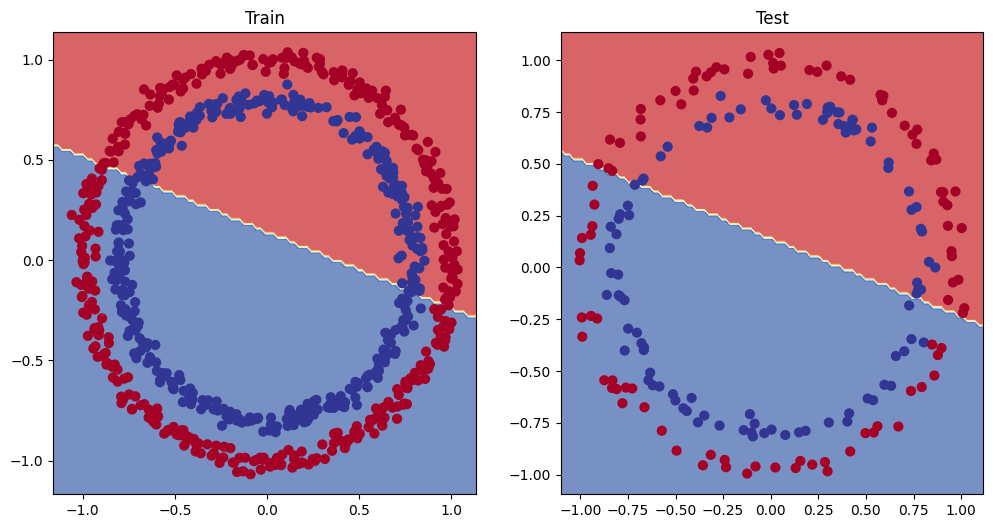

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improve Model

In [34]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2306, -0.4762],
                      [ 0.4338,  0.4286],
                      [-0.5192,  0.2816],
                      [-0.1547,  0.0850],
                      [-0.6344,  0.1845]])),
             ('0.bias', tensor([-0.4486,  0.1564, -0.4384, -0.3111,  0.4880])),
             ('1.weight',
              tensor([[-2.7342e-04, -4.6825e-02,  3.0059e-02, -3.6922e-01,  5.3008e-02]])),
             ('1.bias', tensor([-0.1158]))])

In [35]:
X_train[:1]

tensor([[ 0.6579, -0.4651]], device='cuda:0')

In [36]:
class CirculeModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10) #x_train have two features
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

    def forward(self,x):
      return self.layer_3(self.layer_2(self.layer_1(x)))


In [37]:
model_1 = CirculeModelV1().to(device)
model_1

CirculeModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
class CirculeModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10) #x_train have two features
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


In [39]:
model_1 = CirculeModelV1().to(device)
model_1

CirculeModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=y_test)

  if epoch % 100 == 0:
    print(f"Epoch:{epochs} | LOSS:{loss:.5f} |Acc:{acc:.2f}  | Test Loss:{test_loss:.2f} Test Acc:{test_acc:.2f} " )




Epoch:1000 | LOSS:0.69532 |Acc:49.12  | Test Loss:0.70 Test Acc:100.00 
Epoch:1000 | LOSS:0.69337 |Acc:50.12  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69308 |Acc:50.62  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69302 |Acc:51.38  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69299 |Acc:51.00  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69299 |Acc:51.00  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:50.88  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.25  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.62  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.50  | Test Loss:0.69 Test Acc:100.00 


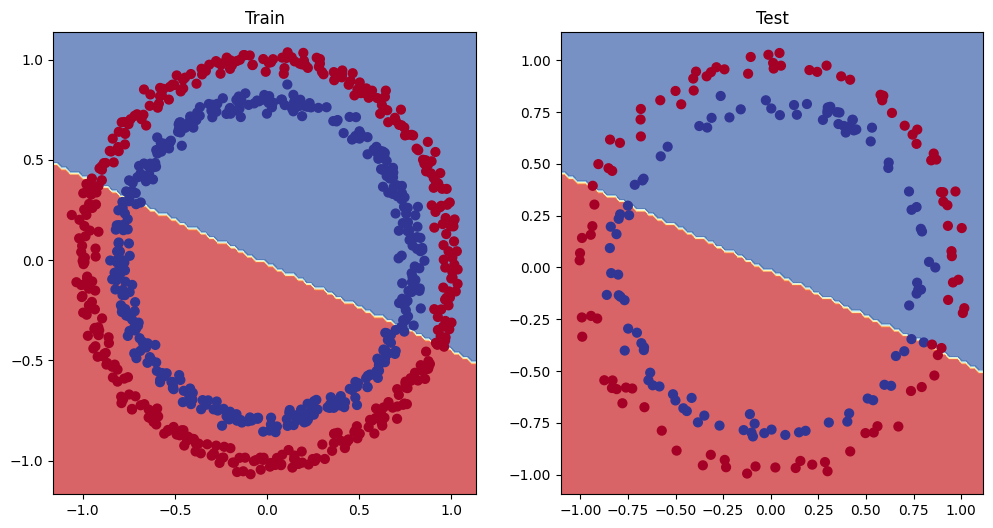

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fix a strainght line

In [42]:
weight =0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [43]:
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]



print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


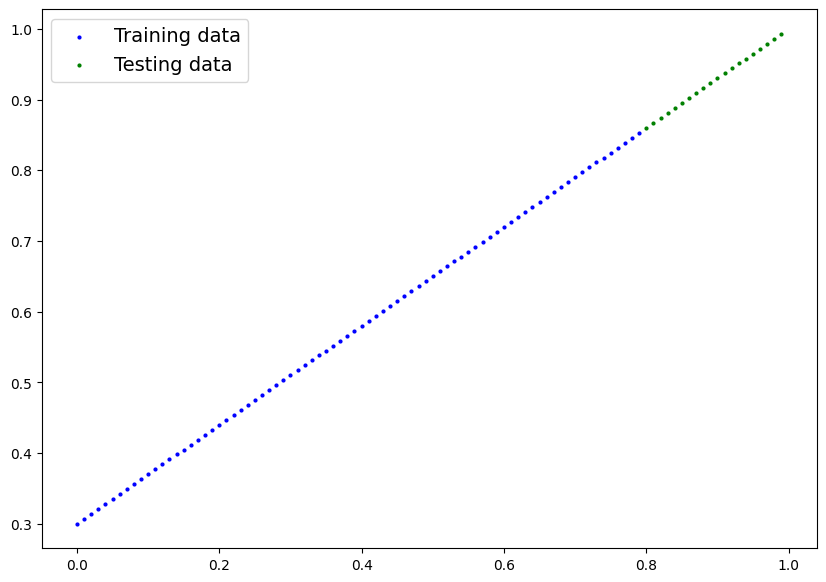

In [44]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [45]:
X_train_regression[:10],y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

### 5.2 Adjuisting model_1 to fit a Straight line

In [46]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [47]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr = 0.01)

In [48]:
epochs = 1000

X_train_regression ,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)

  loss = loss_fn(y_pred,y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.54924, Test loss: 0.73354
Epoch: 100 | Train loss: 0.01561, Test loss: 0.07682
Epoch: 200 | Train loss: 0.01563, Test loss: 0.07391
Epoch: 300 | Train loss: 0.01870, Test loss: 0.07172
Epoch: 400 | Train loss: 0.01797, Test loss: 0.07230
Epoch: 500 | Train loss: 0.01861, Test loss: 0.06912
Epoch: 600 | Train loss: 0.02054, Test loss: 0.06855
Epoch: 700 | Train loss: 0.02113, Test loss: 0.06746
Epoch: 800 | Train loss: 0.02044, Test loss: 0.06632
Epoch: 900 | Train loss: 0.02006, Test loss: 0.06468


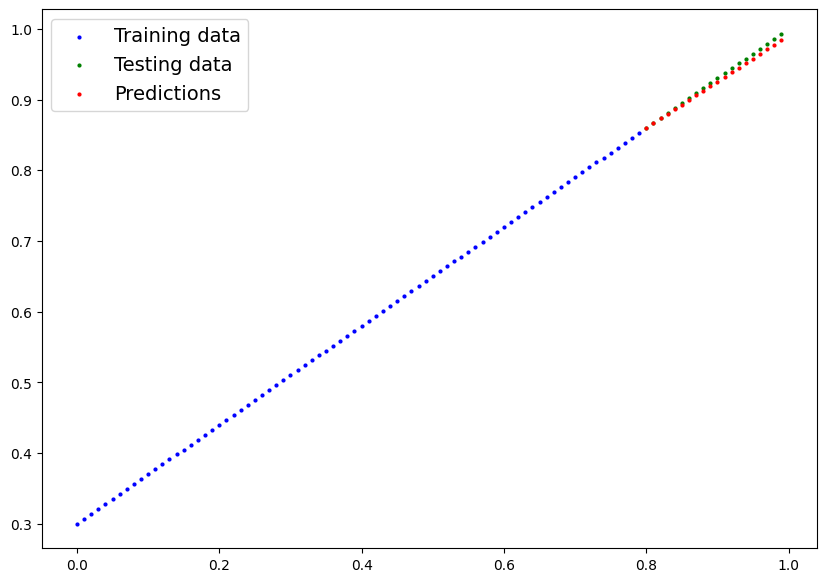

In [49]:

model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# matplotlib can't handle data on the GPU

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

### 6.1 Recreting non-liner data

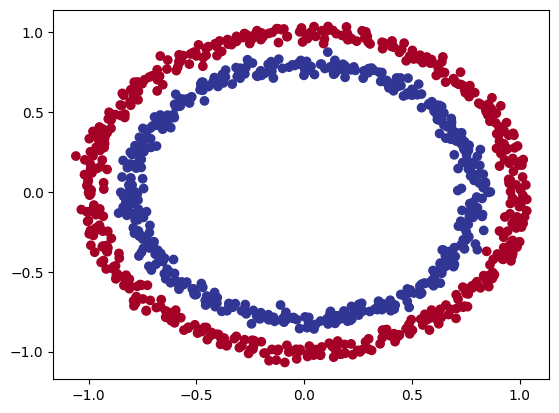

In [50]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [51]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size = 0.2,
                                                 random_state=42)

### 6.2 Building a Model with NoN-Linearity

In [52]:
from torch import  nn

class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [53]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr = 0.1)

### Training model Non-linearity

In [54]:
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

In [55]:
epochs = 1000

for epoch in range(epochs):
  model_3.train()
  y_logit = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logit))

  loss = loss_fn(y_logit,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():

    #forward pass
    test_logit = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logit))

    #cal loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")





Epoch: 0 | Loss: 0.70503, Accuracy: 50.00% | Test Loss: 0.69464, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69245, Accuracy: 50.88% | Test Loss: 0.69464, Test Accuracy: 52.00%
Epoch: 200 | Loss: 0.69095, Accuracy: 52.00% | Test Loss: 0.69464, Test Accuracy: 53.50%
Epoch: 300 | Loss: 0.68937, Accuracy: 53.62% | Test Loss: 0.69464, Test Accuracy: 53.50%
Epoch: 400 | Loss: 0.68714, Accuracy: 54.62% | Test Loss: 0.69464, Test Accuracy: 54.50%
Epoch: 500 | Loss: 0.68384, Accuracy: 55.38% | Test Loss: 0.69464, Test Accuracy: 55.50%
Epoch: 600 | Loss: 0.67850, Accuracy: 58.50% | Test Loss: 0.69464, Test Accuracy: 58.50%
Epoch: 700 | Loss: 0.67091, Accuracy: 63.75% | Test Loss: 0.69464, Test Accuracy: 60.00%
Epoch: 800 | Loss: 0.65911, Accuracy: 68.38% | Test Loss: 0.69464, Test Accuracy: 59.50%
Epoch: 900 | Loss: 0.64040, Accuracy: 77.25% | Test Loss: 0.69464, Test Accuracy: 70.50%


In [56]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 0., 1., 1., 1., 0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

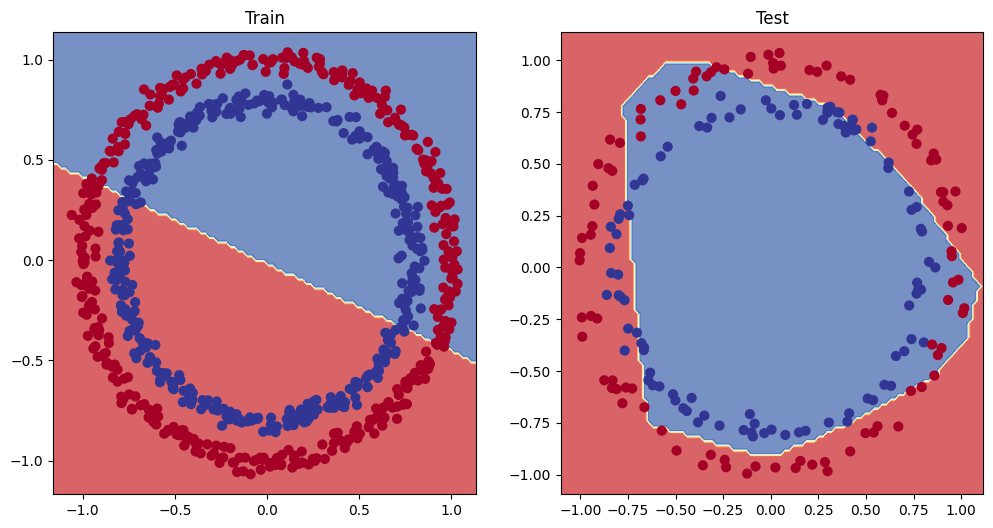

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [58]:
A = torch.arange(-10,10,1,dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

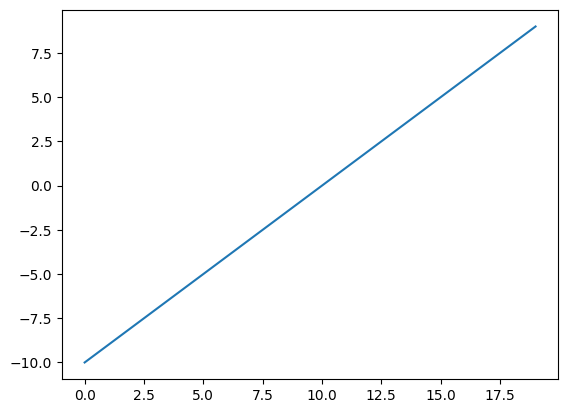

In [59]:
plt.plot(A)

In [60]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

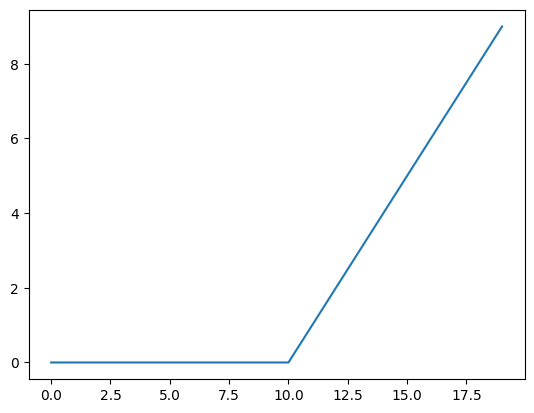

In [61]:
plt.plot(relu(A))

In [62]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

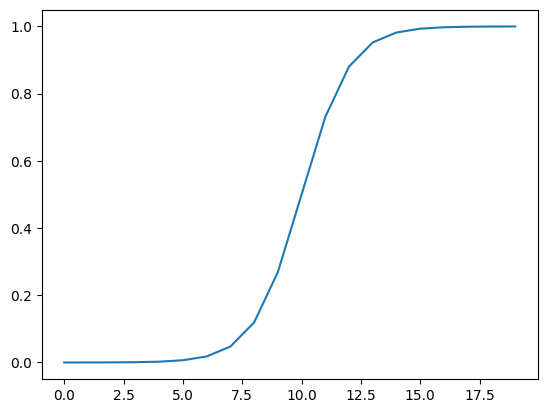

In [63]:
plt.plot(sigmoid(A))

##8. Putting things together by building a multi-class PyTorch model

###8.1 Creating multi-class classification data

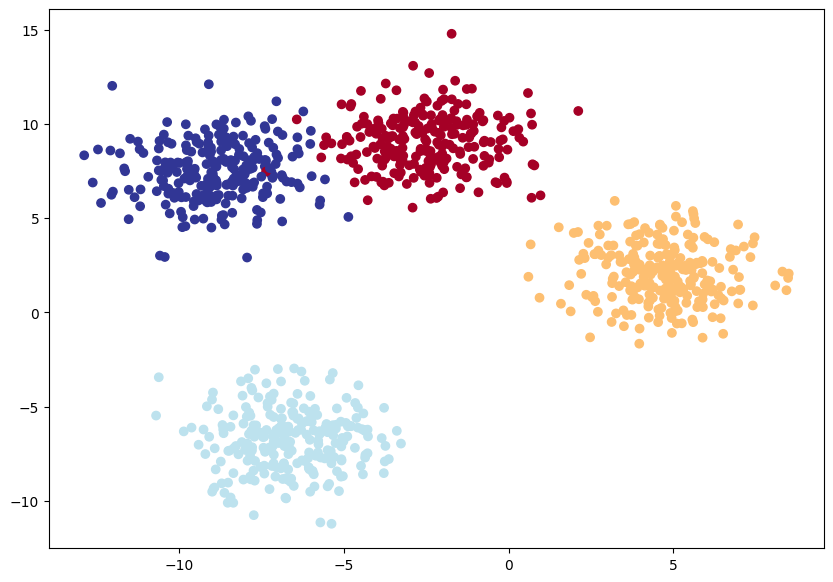

In [64]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob,y_blob = make_blobs(n_samples =1000,
                          n_features = NUM_FEATURES,
                          centers = NUM_CLASSES,
                          cluster_std = 1.5,
                          random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,
                                                 y_blob,
                                                 test_size=0.2,
                                                 random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);



In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 8.2 Building a multi-clss classification model

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [67]:
class BlobModel(nn.Module):
  def __init__ (self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),

            nn.Linear(in_features=hidden_units, out_features=hidden_units),

            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
  def forward(self,x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 loss function and optimizer

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimezer = torch.optim.SGD(params = model_4.parameters(),
                            lr = 0.1)


###8.4 Getting prediction probabilities for a multi-class PyTorch model

In [69]:
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.5586,  1.9707,  0.2615, -0.6274],
        [ 0.6403, -0.8193, -3.8548,  1.8561],
        [-0.4936, -2.7774, -0.5642, -0.1539],
        [-0.1805, -1.9219, -1.0563,  0.1500],
        [ 0.4999, -1.0561, -3.4398,  1.6027]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [70]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [71]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [72]:
y_logits = model_4(X_blob_test.to(device))


y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.6076,  1.8278, -0.1815, -0.3592],
        [ 0.3387, -2.7179, -4.8026,  2.4206],
        [-0.3636, -1.9850, -0.1899, -0.3765],
        [ 0.4074,  1.5029,  0.4266, -0.7304],
        [ 0.7499,  0.0635, -3.2549,  1.4970]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[1.9147e-01, 6.4873e-01, 8.6981e-02, 7.2821e-02],
        [1.1022e-01, 5.1861e-03, 6.4482e-04, 8.8395e-01],
        [2.9634e-01, 5.8566e-02, 3.5257e-01, 2.9253e-01],
        [1.8760e-01, 5.6103e-01, 1.9123e-01, 6.0132e-02],
        [2.7530e-01, 1.3858e-01, 5.0179e-03, 5.8110e-01]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [73]:
torch.sum(y_pred_probs[0])
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1915, 0.6487, 0.0870, 0.0728], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


In [74]:
y_logit.dtype,y_blob_train.dtype

(torch.float32, torch.int64)

In [75]:
epochs = 100

X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train).squeeze()

  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimezer.zero_grad()
  loss.backward()
  optimezer.step()

  model_4.eval()
  with torch.inference_mode():

      #orward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      #Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)
      if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.90827, Acc: 57.38% | Test Loss: 0.76222, Test Acc: 68.00%
Epoch: 10 | Loss: 0.17404, Acc: 99.00% | Test Loss: 0.15973, Test Acc: 99.00%
Epoch: 20 | Loss: 0.09423, Acc: 99.38% | Test Loss: 0.08551, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06655, Acc: 99.38% | Test Loss: 0.05870, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05338, Acc: 99.38% | Test Loss: 0.04555, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04589, Acc: 99.38% | Test Loss: 0.03793, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04113, Acc: 99.25% | Test Loss: 0.03300, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03788, Acc: 99.12% | Test Loss: 0.02958, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03553, Acc: 99.12% | Test Loss: 0.02706, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03377, Acc: 99.12% | Test Loss: 0.02514, Test Acc: 99.50%


In [76]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  8.1900,  13.6094,  -9.9769,  -5.3768],
        [  1.5365, -13.6448,  -0.5056,   6.8941],
        [-11.5419, -17.1691,  13.8417,   5.6093],
        [  4.2808,   9.7397,  -5.4481,  -4.3313],
        [ 10.2903,   5.6515, -11.5536,  -0.8436],
        [  1.2453, -17.1054,   0.1025,   8.5823],
        [-10.9507, -13.3833,  12.8838,   3.8265],
        [  7.7516,   0.5177,  -8.3891,   1.1657],
        [-13.2964, -23.5939,  16.2743,   8.4583],
        [  8.5294,   2.3704,  -9.3825,   0.4080]], device='cuda:0')

In [77]:
y_pred_probs = torch.softmax(y_logits, dim=1)


y_preds = y_pred_probs.argmax(dim=1)


print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


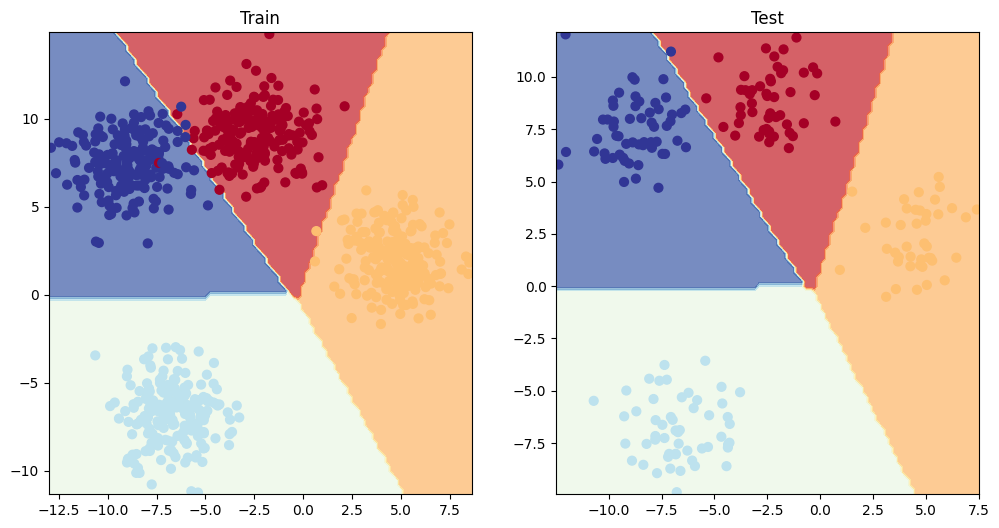

In [78]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

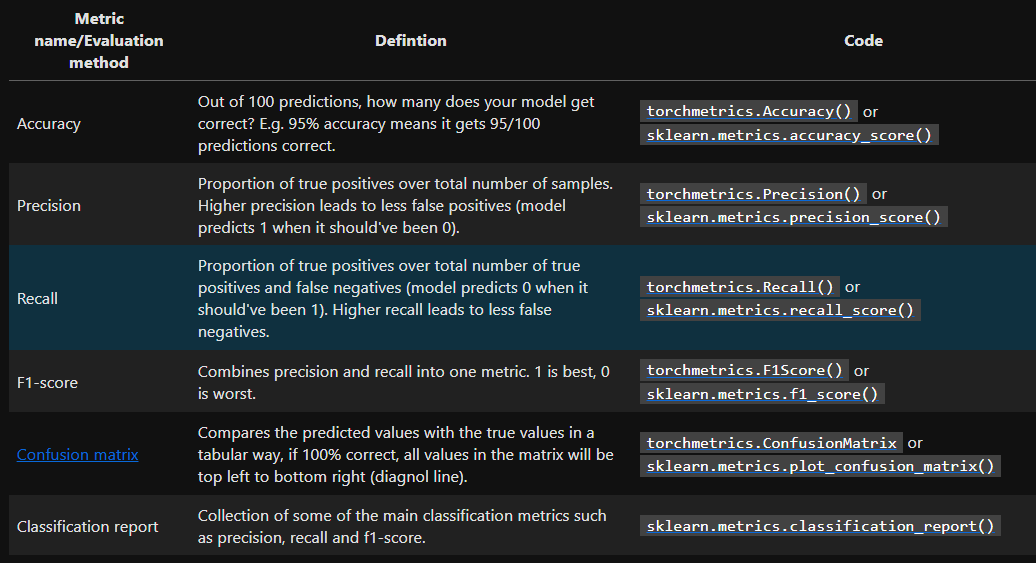

In [79]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy


torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

#Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')